# Visualizing Embedding Evolution During Training

In this notebook, we train an MLP on MNIST and visualize how hidden representations (embeddings) evolve over training using t-SNE. This gives insight into how class structure emerges in the latent space over time.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [14]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#train_subset, _ = torch.utils.data.random_split(train_data, [10000, len(train_data)-10000])
#train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [15]:
from torch.utils.data import Subset

# First, get all test labels
test_targets = test_data.targets.numpy()

# Define how many samples per class
samples_per_class = 200
num_classes = 10

# Collect indices (balanced subset)
selected_indices = []
for class_id in range(num_classes):
    class_indices = np.where(test_targets == class_id)[0]
    chosen = np.random.choice(class_indices, size=samples_per_class, replace=False)
    selected_indices.extend(chosen)

# Create a test subset DataLoader (shuffling not needed)
test_subset = Subset(test_data, selected_indices)
test_subset_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

In [16]:
print(len(train_data))
print(len(test_data))
print(len(test_subset))

60000
10000
2000


In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, return_embedding=False):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        if return_embedding:
            return out, h
        return out

model = MLP().to(device)

In [18]:
# Training parameters
epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Embeddings
# train_embeddings_all = []
# test_embeddings_all = []
# train_labels_all = []
# test_labels_all = []
test_subset_embeddings = []
test_subset_labels = []


for epoch in range(epochs):
    # === Train phase ===
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    epoch_train_embeddings = []
    epoch_train_labels = []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, embedding = model(data, return_embedding=True)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Metrics
        epoch_train_loss += loss.item()
        _, preds = torch.max(output, dim=1)
        correct_train += (preds == target).sum().item()
        total_train += target.size(0)

        with torch.no_grad():
            batch_embeddings = []
            batch_labels = []

            for data_sub, target_sub in test_subset_loader:
                data_sub, target_sub = data_sub.to(device), target_sub.to(device)
                _, emb = model(data_sub, return_embedding=True)
                batch_embeddings.append(emb.cpu().numpy())
                batch_labels.append(target_sub.cpu().numpy())

            test_subset_embeddings.append(np.concatenate(batch_embeddings, axis=0))
            test_subset_labels.append(np.concatenate(batch_labels, axis=0))

        # Store embeddings
        #epoch_train_embeddings.append(embedding.cpu().detach().numpy())
        #epoch_train_labels.append(target.cpu().numpy())

    train_loss = epoch_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    #train_embeddings_all.append(np.concatenate(epoch_train_embeddings, axis=0))
    #train_labels_all.append(np.concatenate(epoch_train_labels, axis=0))

    # === Eval phase ===
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0
    epoch_val_embeddings = []
    epoch_val_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data, return_embedding=True)
            loss = criterion(output, target)

            epoch_val_loss += loss.item()
            _, preds = torch.max(output, dim=1)
            correct_val += (preds == target).sum().item()
            total_val += target.size(0)

            #epoch_val_embeddings.append(embedding.cpu().numpy())
            #epoch_val_labels.append(target.cpu().numpy())

    val_loss = epoch_val_loss / len(test_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    #test_embeddings_all.append(np.concatenate(epoch_val_embeddings, axis=0))
    #test_labels_all.append(np.concatenate(epoch_val_labels, axis=0))

    # === Print summary ===
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"| Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# Epoch [50/50] | Train Loss: 0.0562, Acc: 0.9851 | Val Loss: 0.0848, Acc: 0.9739
# Epoch [10/10] | Train Loss: 0.0370, Acc: 0.9894 | Val Loss: 0.0796, Acc: 0.9764

Epoch [1/10] | Train Loss: 0.4098, Acc: 0.8912 | Val Loss: 0.2230, Acc: 0.9341
Epoch [2/10] | Train Loss: 0.1934, Acc: 0.9456 | Val Loss: 0.1621, Acc: 0.9513
Epoch [3/10] | Train Loss: 0.1414, Acc: 0.9590 | Val Loss: 0.1275, Acc: 0.9620
Epoch [4/10] | Train Loss: 0.1090, Acc: 0.9685 | Val Loss: 0.1084, Acc: 0.9672
Epoch [5/10] | Train Loss: 0.0875, Acc: 0.9743 | Val Loss: 0.0966, Acc: 0.9709
Epoch [6/10] | Train Loss: 0.0725, Acc: 0.9790 | Val Loss: 0.0870, Acc: 0.9739
Epoch [7/10] | Train Loss: 0.0612, Acc: 0.9822 | Val Loss: 0.0803, Acc: 0.9751
Epoch [8/10] | Train Loss: 0.0512, Acc: 0.9856 | Val Loss: 0.0777, Acc: 0.9762
Epoch [9/10] | Train Loss: 0.0441, Acc: 0.9874 | Val Loss: 0.0757, Acc: 0.9758
Epoch [10/10] | Train Loss: 0.0371, Acc: 0.9893 | Val Loss: 0.0721, Acc: 0.9784


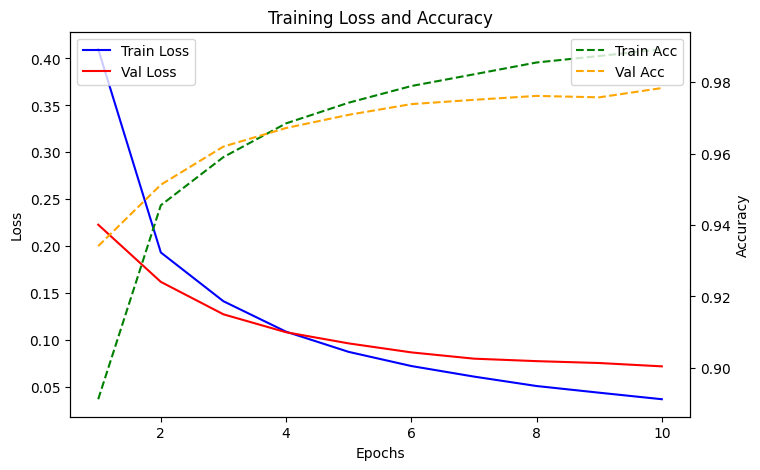

In [22]:
epochs_range = range(1, epochs + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss')
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(epochs_range, train_accuracies, 'g--', label='Train Acc')
ax2.plot(epochs_range, val_accuracies, 'orange', linestyle='--', label='Val Acc')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Training Loss and Accuracy')
plt.show()

# Video Animation
New

In [23]:
len(test_subset_embeddings)

4690

/tmp/ipykernel_145095/1554730617.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter([], [], s=10, cmap='tab1', alpha=0.6)


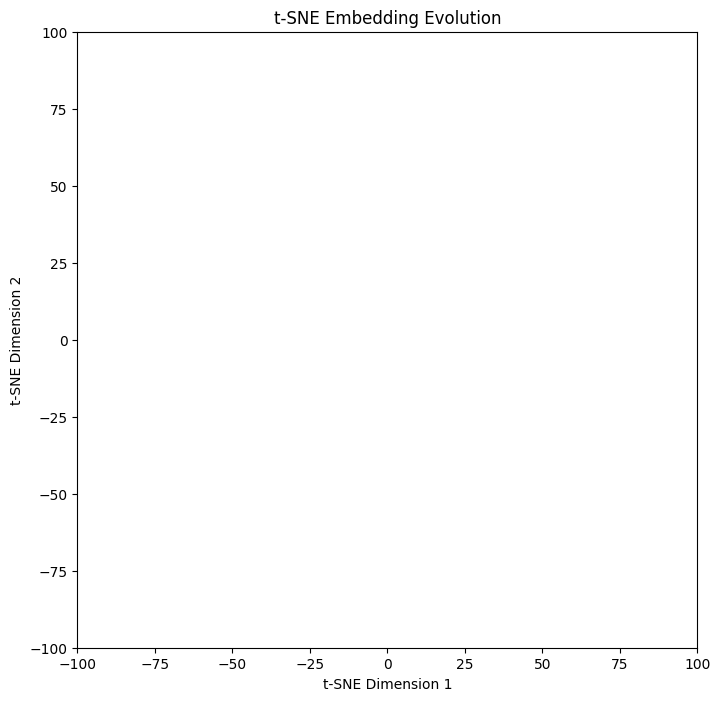

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
import os


# === Interpolation between t-SNE results ===
def interpolate_tsne(embeddings_list, steps=10):
    interpolated = []
    for a, b in zip(embeddings_list[:-1], embeddings_list[1:]):
        for alpha in np.linspace(0, 1, steps, endpoint=False):
            interp = (1 - alpha) * a + alpha * b
            interpolated.append(interp)
    interpolated.append(embeddings_list[-1])  # include final frame
    return interpolated


# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(test_subset_embeddings[0])
tsne_results.append(result)

# Subsequent epochs
for epoch in range(1, 5): #range(1, len(test_subset_embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42, min_grad_norm=1e-3, n_iter_without_progress=1)
    result = tsne.fit_transform(test_subset_embeddings[epoch])
    tsne_results.append(result)

# === Interpolate between epochs ===
#tsne_results_interp = interpolate_tsne(tsne_results, steps=5)
tsne_results_interp=tsne_results

# === Animation setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], s=10, cmap='tab1', alpha=0.6)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title('t-SNE Embedding Evolution')


def update(frame):
    scatter.set_offsets(tsne_results_interp[frame])
    scatter.set_array(sampled_labels)
    title.set_text(f't-SNE Embedding Evolution – Frame {frame + 1}')
    return scatter,

In [100]:
ani = animation.FuncAnimation(fig, update, frames=len(tsne_results_interp), interval=50, blit=True)

In [101]:
from IPython.display import HTML

HTML(ani.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")

# tSNE Computation

In [ ]:
# Labels should be the same everywhere
print(labels[0])
print(labels[1])

In [ ]:
embeddings[0]

In [ ]:
# Final epoch's data
final_embeddings = embeddings[-1]
final_labels = labels[-1]

# Convert to NumPy arrays (if not already)
final_embeddings = np.array(final_embeddings)
final_labels = np.array(final_labels)

# How many samples per class
samples_per_class = 200
num_classes = 10

# Collect indices
selected_indices = []
for class_id in range(num_classes):
    class_indices = np.where(final_labels == class_id)[0]
    chosen = np.random.choice(class_indices, size=samples_per_class, replace=False)
    selected_indices.extend(chosen)

# Subsample embeddings and labels
sampled_embeddings = final_embeddings[selected_indices]
sampled_labels = final_labels[selected_indices]

In [ ]:
# Optional: Refresh tSNE
epoch = 10

# Final epoch's data
final_embeddings = embeddings[epoch]
final_labels = labels[epoch]

# Subsample embeddings and labels
sampled_embeddings = final_embeddings[selected_indices]
sampled_labels = final_labels[selected_indices]

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(sampled_embeddings)

# Plot
plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sampled_labels, cmap='tab10', alpha=0.8)
plt.title('t-SNE of Final Epoch Embeddings (Balanced Sample)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Digit Label')
plt.show()

# Animation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0: PCA init
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Epochs 1+: use previous output for init
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Animation Setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], c=[], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE Embedding Evolution')

# Use sampled_labels once — they're fixed
def update(frame):
    scatter.set_offsets(tsne_results[frame])
    scatter.set_array(sampled_labels)
    ax.set_title(f't-SNE Embedding – Epoch {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results), interval=1000, blit=True)
#plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Static figure (inline mode is fine)
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the initial frame (epoch 0)
sc = ax.scatter(
    tsne_results[0][:, 0], tsne_results[0][:, 1],
    c=sampled_labels, cmap='tab10', alpha=0.7
)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title("t-SNE Embedding – Epoch 1")

# Update function for slider
def update_epoch(epoch):
    print(epoch)
    sc.set_offsets(tsne_results[epoch])
    title.set_text(f't-SNE Embedding – Epoch {epoch + 1}')
    fig.canvas.draw_idle()

# IntSlider widget
epoch_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(tsne_results) - 1,
    step=1,
    description='Epoch:',
    continuous_update=True
)

# Connect slider to update function
widgets.interact(update_epoch, epoch=epoch_slider)

In [ ]:
import os

# === Define experiment info ===
model_name = model._get_name()
# Build a base name with settings
base_name = f"tsne_{model_name}_e{epochs}_lr{learning_rate:.0e}"  # e.g., tsne_MLP_e10_lr1e-03

# Auto-increment file index
i = 1
while os.path.exists(f"{base_name}_{i:03}.gif"):
    i += 1
filename = f"{base_name}_{i:03}.gif"

# Save the animation
ani.save(filename, writer='pillow')
print(f"Saved animation as {filename}")

# Video Animation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
import os

# === Interpolation between t-SNE results ===
def interpolate_tsne(embeddings_list, steps=10):
    interpolated = []
    for a, b in zip(embeddings_list[:-1], embeddings_list[1:]):
        for alpha in np.linspace(0, 1, steps, endpoint=False):
            interp = (1 - alpha) * a + alpha * b
            interpolated.append(interp)
    interpolated.append(embeddings_list[-1])  # include final frame
    return interpolated

# === Compute t-SNE per epoch using selected_indices ===
tsne_results = []

# Epoch 0
tsne = TSNE(n_components=2, init='pca', random_state=42)
result = tsne.fit_transform(embeddings[0][selected_indices])
tsne_results.append(result)

# Subsequent epochs
for epoch in range(1, len(embeddings)):
    tsne = TSNE(n_components=2, init=tsne_results[-1], random_state=42)
    result = tsne.fit_transform(embeddings[epoch][selected_indices])
    tsne_results.append(result)

# === Interpolate between epochs ===
tsne_results_interp = interpolate_tsne(tsne_results, steps=5)

# === Animation setup ===
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter([], [], cmap='tab10', alpha=0.7)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
title = ax.set_title('t-SNE Embedding Evolution')

def update(frame):
    scatter.set_offsets(tsne_results_interp[frame])
    scatter.set_array(sampled_labels)
    title.set_text(f't-SNE Embedding Evolution – Frame {frame + 1}')
    return scatter,

ani = animation.FuncAnimation(fig, update, frames=len(tsne_results_interp), interval=100, blit=True)

In [ ]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
# === Save as MP4 (with ffmpeg) ===
model_name = model._get_name()
lr = learning_rate
base_name = f"tsne_{model_name}_e{epochs}_lr{lr:.0e}"
i = 1
while os.path.exists(f"{base_name}_{i:03}.mp4"):
    i += 1
filename = f"{base_name}_{i:03}.mp4"

ani.save(filename, writer='ffmpeg', dpi=150)
print(f"Saved animation as {filename}")